# Import tools

In [1]:
import pandas as pd
import os
from PIL import Image

import matplotlib.patches as patches
import random
import time
import torch

import shutil


from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt

from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


# Dataset pre-processing

## load img and label, show some example


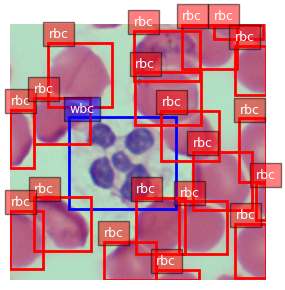

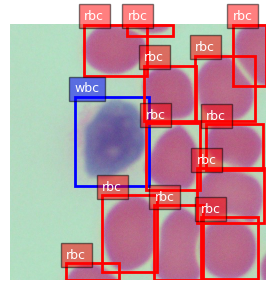

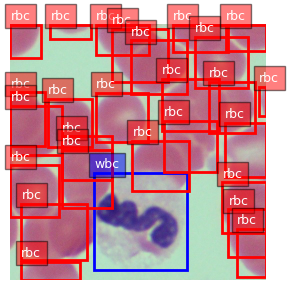

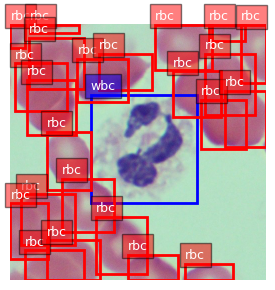

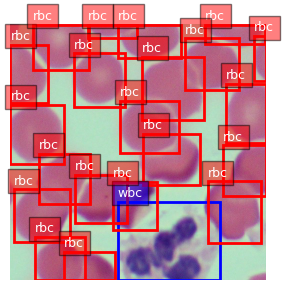

In [2]:
# load CSV
ann_path = '/kaggle/input/blood-cell-detection-dataset/annotations.csv'
df = pd.read_csv(ann_path)

# df.head()

# radom select img
image_dir = '/kaggle/input/blood-cell-detection-dataset/images'
sample_images = df['image'].unique()
sample_images = random.sample(list(sample_images), 5)

# show box
def show_image_with_boxes(image_path, annotations_df):
    img = Image.open(image_path)
    w, h = img.size
    # print(w)

    fig, ax = plt.subplots(1, figsize=(3, 3))
    ax.imshow(img)
    boxes = annotations_df[annotations_df['image'] == os.path.basename(image_path)]

    for _, row in boxes.iterrows():
        x1, y1, x2, y2 = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        width, height = x2 - x1, y2 - y1
        label = row['label']

        rect = patches.Rectangle((x1, y1), width, height, linewidth=2,
                                 edgecolor='r' if label == 'rbc' else 'b', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, label, color='white', fontsize=9,
                bbox=dict(facecolor='red' if label == 'rbc' else 'b', alpha=0.5))

    plt.axis('off')
    plt.tight_layout()
    plt.show()
# show
for img_file in sample_images:
    img_path = os.path.join(image_dir, img_file)
    show_image_with_boxes(img_path, df)


## Divide the dataset and save it

In [3]:
src_image_dir = "/kaggle/input/blood-cell-detection-dataset"

# label map
label_map = {'rbc': 0, 'wbc': 1}
df['class_id'] = df['label'].map(label_map)

# divide to train and val(test)
image_ids = df['image'].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
df_train = df[df['image'].isin(train_ids)]
df_val = df[df['image'].isin(val_ids)]
# save
# ensure every model use same subset, keep result fair
for subset in ['train', 'val']:
    os.makedirs(f"/kaggle/working/images/{subset}", exist_ok=True)
    os.makedirs(f"/kaggle/working/labels/{subset}", exist_ok=True)
os.makedirs("/kaggle/working/coco", exist_ok=True)

## prepare yolo data format


In [4]:
def convert_to_yolo_and_copy(df, subset):
    for image_name in df['image'].unique():
        # load img
        image_path=os.path.join(src_image_dir, 'images' )
        # print(image_path)
        src_path = os.path.join(image_path, image_name)
        dst_path = f"/kaggle/working/images/{subset}/{image_name}"
        shutil.copy(src_path, dst_path)

        img = Image.open(src_path)
        w, h = img.size

        # convert lable 
        label_file = image_name.replace(".png", ".txt")
        label_path = f"/kaggle/working/labels/{subset}/{label_file}"

        with open(label_path, 'w') as f:
            for _, row in df[df['image'] == image_name].iterrows():
                x_center = ((row['xmin'] + row['xmax']) / 2) / w
                y_center = ((row['ymin'] + row['ymax']) / 2) / h
                bbox_w = (row['xmax'] - row['xmin']) / w
                bbox_h = (row['ymax'] - row['ymin']) / h
                f.write(f"{row['class_id']} {x_center:.6f} {y_center:.6f} {bbox_w:.6f} {bbox_h:.6f}\n")

convert_to_yolo_and_copy(df_train, 'train')
convert_to_yolo_and_copy(df_val, 'val')

# yaml
yaml_content = """
path: /kaggle/working
train: images/train
val: images/val

nc: 2
names: ['rbc', 'wbc']
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(yaml_content)

## prepare coco format(suit for frcnn ssd)

In [5]:
def convert_to_coco(df, subset, output_json_path):
    images = []
    annotations = []
    categories = [{'id': 0, 'name': 'rbc'}, {'id': 1, 'name': 'wbc'}]
    image_id_map = {}
    ann_id = 1

    for img_id, image_name in enumerate(df['image'].unique()):
        img_path = os.path.join("/kaggle/working/images", subset, image_name)
        w, h = Image.open(img_path).size

        images.append({
            "id": img_id,
            "file_name": image_name,
            "width": w,
            "height": h
        })
        image_id_map[image_name] = img_id

    for _, row in df.iterrows():
        img_id = image_id_map[row['image']]
        x = row['xmin']
        y = row['ymin']
        w_box = row['xmax'] - row['xmin']
        h_box = row['ymax'] - row['ymin']
        annotations.append({
            "id": ann_id,
            "image_id": img_id,
            "category_id": int(row['class_id'])+1,
            "bbox": [x, y, w_box, h_box],
            "area": w_box * h_box,
            "iscrowd": 0
        })
        ann_id += 1

    coco_dict = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    with open(output_json_path, 'w') as f:
        json.dump(coco_dict, f, indent=4)


class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_file, transforms=None):
        self.dataset = CocoDetection(image_dir, annotation_file)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, targets = self.dataset[idx]
        img_id = self.dataset.ids[idx]

        boxes = []
        labels = []
        for t in targets:
            x, y, w, h = t['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(t['category_id'])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([img_id])}
        if self.transforms:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.dataset)



In [6]:
convert_to_coco(df_train, 'train', '/kaggle/working/coco/coco_train.json')
convert_to_coco(df_val, 'val', '/kaggle/working/coco/coco_val.json')

transform = ToTensor()

train_dataset = CocoDataset('/kaggle/working/images/train', '/kaggle/working/coco/coco_train.json', transform)
val_dataset = CocoDataset('/kaggle/working/images/val', '/kaggle/working/coco/coco_val.json', transform)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Fine-tine models and evaluate 

## yolov8 model

In [7]:
   !pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.1/994.1 kB 35.1 MB/s eta 0:00:00


### train yolo v8

In [8]:
import ultralytics
from ultralytics import YOLO

# load pre_training model
model = YOLO("yolov8n.pt")

model.train(data="/kaggle/working/data.yaml", epochs=50, imgsz=256)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 175MB/s]


Ultralytics 8.3.104 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

100%|██████████| 755k/755k [00:00<00:00, 38.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 160MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/labels/train... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<00:00, 801.79it/s]

train: New cache created: /kaggle/working/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/labels/val... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 490.06it/s]

val: New cache created: /kaggle/working/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.578G      1.612      3.878      1.521        504        256: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         20        458     0.0444      0.735     0.0432     0.0227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.598G      1.412       3.77      1.398        466        256: 100%|██████████| 5/5 [00:00<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]

                   all         20        458     0.0535      0.797      0.092     0.0498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       0.6G      1.271      3.471        1.3        480        256: 100%|██████████| 5/5 [00:00<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]

                   all         20        458     0.0593      0.848      0.144     0.0893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.607G      1.182      3.022      1.203        553        256: 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]

                   all         20        458     0.0618       0.86      0.208       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.609G      1.182      2.778      1.177        559        256: 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


                   all         20        458     0.0616      0.871      0.293      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.609G      1.146      2.429      1.128        565        256: 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]

                   all         20        458      0.986      0.206      0.341      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.609G      1.174      2.163      1.114        552        256: 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         20        458      0.992      0.269      0.615      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.609G      1.177      1.857      1.083        462        256: 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]

                   all         20        458      0.995      0.616      0.856      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.609G      1.192      1.782      1.074        517        256: 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


                   all         20        458      0.923      0.767      0.896      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.609G      1.135      1.538      1.042        572        256: 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]

                   all         20        458      0.843       0.77      0.872      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.609G      1.108      1.396      1.043        577        256: 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]

                   all         20        458       0.95      0.771      0.901      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.609G      1.092      1.282      1.034        558        256: 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]

                   all         20        458      0.945      0.853      0.944      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.609G      1.047      1.184      1.033        523        256: 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]

                   all         20        458      0.914      0.885       0.95      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.609G      1.068      1.148      1.018        556        256: 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]

                   all         20        458      0.848      0.877      0.939       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.609G      1.019      1.076      1.018        620        256: 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]

                   all         20        458      0.974      0.864      0.934       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.609G      1.041      1.101      1.017        530        256: 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]

                   all         20        458      0.976        0.9      0.947      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.609G       1.06     0.9991      1.032        482        256: 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]

                   all         20        458      0.973      0.877      0.947      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.609G      1.025      1.007      1.005        490        256: 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]

                   all         20        458      0.902      0.927       0.95      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.609G      1.002     0.9886     0.9905        659        256: 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]

                   all         20        458      0.897      0.916      0.947      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.609G     0.9536      0.925     0.9994        541        256: 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


                   all         20        458      0.934      0.944      0.963      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.609G      0.953     0.8708     0.9983        558        256: 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         20        458      0.949      0.954      0.966      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.609G     0.9486     0.9096     0.9851        568        256: 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]

                   all         20        458      0.943      0.963      0.957      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.609G     0.9175     0.8621     0.9817        594        256: 100%|██████████| 5/5 [00:00<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         20        458      0.945       0.96       0.95       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.609G     0.9033     0.8524     0.9782        570        256: 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         20        458       0.94      0.958      0.941      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.611G     0.9121     0.8199     0.9862        643        256: 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         20        458      0.929      0.962       0.94      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.611G     0.8802     0.7947     0.9639        537        256: 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]

                   all         20        458       0.93      0.959      0.942      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.611G     0.8813     0.7723     0.9751        628        256: 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]

                   all         20        458      0.937      0.952      0.946       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.611G     0.8596     0.7711      0.975        428        256: 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]

                   all         20        458      0.951      0.957      0.964      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.611G     0.8384     0.7642      0.963        577        256: 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]

                   all         20        458      0.962      0.951      0.967      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.611G     0.9137     0.8242     0.9628        676        256: 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]

                   all         20        458      0.967      0.942      0.966      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.611G     0.9063     0.7401      0.975        521        256: 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]

                   all         20        458       0.96      0.944      0.965      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.611G      0.838     0.7554     0.9613        590        256: 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]

                   all         20        458      0.958      0.953      0.962      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.611G      0.843      0.739     0.9591        522        256: 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


                   all         20        458      0.955      0.952      0.958      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.611G     0.8579     0.7298     0.9665        523        256: 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]

                   all         20        458      0.953       0.96      0.959      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.611G     0.8588     0.7509     0.9612        637        256: 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]

                   all         20        458      0.956      0.959      0.962       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.611G     0.8291     0.7031     0.9587        599        256: 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]

                   all         20        458      0.964      0.958      0.966      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.611G     0.8152     0.7135     0.9563        516        256: 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]

                   all         20        458      0.963      0.961      0.968      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.611G     0.7981     0.7013     0.9477        513        256: 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]

                   all         20        458      0.964      0.957      0.967      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.611G     0.7839     0.6695     0.9374        506        256: 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]

                   all         20        458       0.96      0.956      0.966      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.611G     0.8247     0.6888     0.9617        519        256: 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


                   all         20        458      0.956       0.96      0.966      0.805
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.611G     0.7592     0.6146     0.9358        308        256: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


                   all         20        458      0.963      0.954      0.967      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.611G      0.741     0.5963     0.9316        333        256: 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


                   all         20        458      0.965      0.956      0.969      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.611G     0.7311     0.5753     0.9307        322        256: 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]

                   all         20        458       0.97      0.952       0.97      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.611G     0.7217     0.5614     0.9371        329        256: 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]

                   all         20        458      0.973      0.954      0.972      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.611G     0.7241     0.5627     0.9236        347        256: 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]

                   all         20        458       0.98      0.944      0.972       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.611G     0.7313     0.5703     0.9376        313        256: 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         20        458      0.977      0.948      0.972      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.611G     0.7181     0.5657     0.9292        334        256: 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         20        458      0.979      0.951      0.972      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.611G      0.707     0.5603     0.9233        382        256: 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]

                   all         20        458      0.979       0.95      0.972      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.611G     0.7185      0.564      0.932        329        256: 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]

                   all         20        458      0.979       0.95      0.972      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.611G     0.7084     0.5495     0.9259        347        256: 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]

                   all         20        458      0.977      0.949      0.972      0.798



50 epochs completed in 0.013 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.104 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


                   all         20        458      0.963      0.957      0.967       0.81
                   rbc         20        437      0.948      0.961      0.977      0.788
                   wbc         20         21      0.978      0.952      0.958      0.833


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.0ms preprocess, 0.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aeeec545990>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

### val yolov8

In [9]:
# get mAP
# metrics = model.val()
# map50 = metrics.box.map50
# map5095 = metrics.box.map

# get avg_time 
val_images = os.listdir("/kaggle/working/images/val")
sample_imgs = val_images[:5]
infer_times = []
for img_name in sample_imgs:
    img_path = os.path.join("/kaggle/working/images/val", img_name)
    start = time.time()
    results = model(img_path, save=False)
    infer_times.append(time.time() - start)

avg_infer_time_yolo = round(sum(infer_times) / len(infer_times), 4)





image 1/1 /kaggle/working/images/val/image-36.png: 256x256 28 rbcs, 1 wbc, 5.9ms
Speed: 0.7ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /kaggle/working/images/val/image-37.png: 256x256 31 rbcs, 1 wbc, 6.1ms
Speed: 0.4ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /kaggle/working/images/val/image-81.png: 256x256 15 rbcs, 1 wbc, 6.3ms
Speed: 0.4ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /kaggle/working/images/val/image-108.png: 256x256 12 rbcs, 1 wbc, 5.9ms
Speed: 0.4ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /kaggle/working/images/val/image-93.png: 256x256 27 rbcs, 1 wbc, 6.0ms
Speed: 0.4ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 256)


### show sample of yolov8


image 1/1 /kaggle/working/images/val/image-36.png: 256x256 28 rbcs, 1 wbc, 7.8ms
Speed: 0.4ms preprocess, 7.8ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 256)


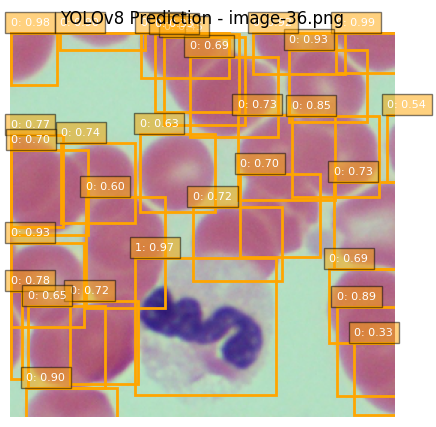


image 1/1 /kaggle/working/images/val/image-37.png: 256x256 31 rbcs, 1 wbc, 7.2ms
Speed: 0.5ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 256)


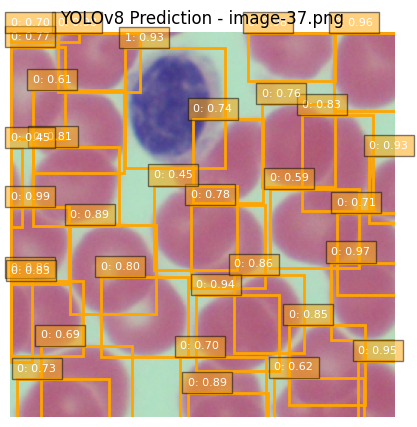


image 1/1 /kaggle/working/images/val/image-81.png: 256x256 15 rbcs, 1 wbc, 8.5ms
Speed: 0.5ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 256)


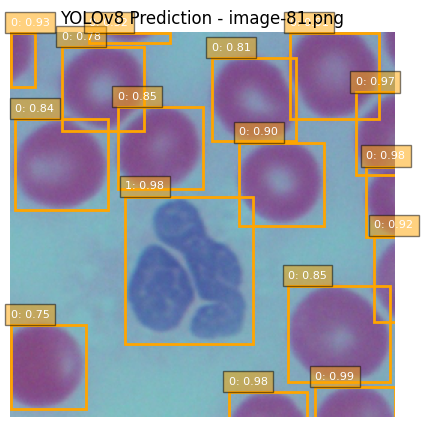


image 1/1 /kaggle/working/images/val/image-108.png: 256x256 12 rbcs, 1 wbc, 7.1ms
Speed: 0.5ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 256)


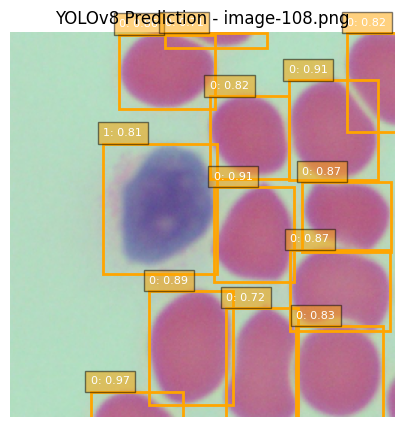


image 1/1 /kaggle/working/images/val/image-93.png: 256x256 27 rbcs, 1 wbc, 6.6ms
Speed: 0.4ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 256)


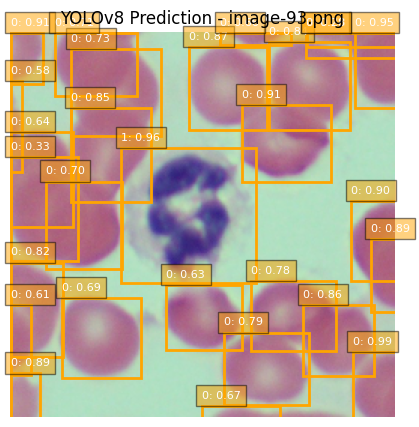

In [10]:
os.makedirs("/kaggle/working/predict/yolo", exist_ok=True)

for img_name in sample_imgs:
    img_path = os.path.join("/kaggle/working/images/val", img_name)
    results = model(img_path)[0]
    image = Image.open(img_path).convert("RGB")
    boxes = results.boxes.xyxy.cpu().numpy()
    confidences = results.boxes.conf.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(image)

    for box, conf, cls in zip(boxes, confidences, classes):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             edgecolor='orange', facecolor='none', linewidth=2)
        ax.add_patch(rect)
        label = f"{int(cls)}: {conf:.2f}"
        ax.text(x1, y1 - 5, label, color='white',
                bbox=dict(facecolor='orange', alpha=0.5), fontsize=8)

    plt.axis("off")
    plt.title(f"YOLOv8 Prediction - {img_name}")
    plt.show()

    plt.savefig(os.path.join("/kaggle/working/predict/yolo", img_name))
    plt.close()


In [11]:
def convert_yolo_results_to_coco(results, filename_to_id, class_id_map, save_path):

    coco_preds = []
    ann_id = 1

    for res in results:
        file_name = os.path.basename(res.path)
        image_id = filename_to_id.get(file_name)

        # if image_id is None:
        #     print(f" image_id: {file_name}")
        #     continue

        boxes = res.boxes.xyxy.cpu().numpy()
        scores = res.boxes.conf.cpu().numpy()
        classes = res.boxes.cls.cpu().numpy()

        for box, score, cls in zip(boxes, scores, classes):
            x1, y1, x2, y2 = box
            coco_box = [float(x1), float(y1), float(x2 - x1), float(y2 - y1)]
            coco_preds.append({
                "id": ann_id,
                "image_id": int(image_id),
                "category_id": int(class_id_map[int(cls)]),
                "bbox": coco_box,
                "score": float(score)
            })
            ann_id += 1

    with open(save_path, "w") as f:
        json.dump(coco_preds, f, indent=4)
    # print(f"YOLO to COCO  {save_path}")



results = model.predict(source="/kaggle/working/images/val", save=False, conf=0.25)
coco_gt = COCO("/kaggle/working/coco/coco_val.json")

filename_to_id = {img["file_name"]: img["id"] for img in coco_gt.dataset["images"]}


class_id_map = {0: 1, 1: 2}

convert_yolo_results_to_coco(
    results=results,
    filename_to_id=filename_to_id,
    class_id_map=class_id_map,
    save_path="/kaggle/working/yolo_preds.json"
)



image 1/20 /kaggle/working/images/val/image-1.png: 256x256 24 rbcs, 1 wbc, 8.9ms
image 2/20 /kaggle/working/images/val/image-100.png: 256x256 25 rbcs, 1 wbc, 6.7ms
image 3/20 /kaggle/working/images/val/image-108.png: 256x256 12 rbcs, 1 wbc, 6.3ms
image 4/20 /kaggle/working/images/val/image-111.png: 256x256 28 rbcs, 1 wbc, 6.2ms
image 5/20 /kaggle/working/images/val/image-113.png: 256x256 30 rbcs, 1 wbc, 5.9ms
image 6/20 /kaggle/working/images/val/image-18.png: 256x256 27 rbcs, 1 wbc, 5.8ms
image 7/20 /kaggle/working/images/val/image-22.png: 256x256 23 rbcs, 1 wbc, 5.9ms
image 8/20 /kaggle/working/images/val/image-36.png: 256x256 28 rbcs, 1 wbc, 5.9ms
image 9/20 /kaggle/working/images/val/image-37.png: 256x256 31 rbcs, 1 wbc, 6.0ms
image 10/20 /kaggle/working/images/val/image-4.png: 256x256 17 rbcs, 1 wbc, 6.1ms
image 11/20 /kaggle/working/images/val/image-44.png: 256x256 26 rbcs, 1 wbc, 6.1ms
image 12/20 /kaggle/working/images/val/image-48.png: 256x256 20 rbcs, 1 wbc, 6.0ms
image 13/2

In [12]:
coco_gt = COCO("/kaggle/working/coco/coco_val.json")
coco_dt = coco_gt.loadRes("/kaggle/working/yolo_preds.json")

coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()



yolo_performance = {
    "model": "YOLOv8n",
    "mAP@0.5": coco_eval.stats[1],
    "mAP@0.5:0.95": coco_eval.stats[0],
    "mAP@0.75": coco_eval.stats[2],
    "avg_infer_time": avg_infer_time_yolo
}
print("YOLOv8 performance:", yolo_performance)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.926
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.530
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.781
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

## Faster R-CNN model


In [13]:
!pip install pycocotools -q

### train frcnn

In [14]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

model_frcnn = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model_frcnn.roi_heads.box_predictor.cls_score.in_features
model_frcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)
model_frcnn.to(device)

optimizer = torch.optim.SGD(model_frcnn.parameters(), lr=0.005, momentum=0.9)
model_frcnn.train()

for epoch in range(100):
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss = sum(model_frcnn(images, targets).values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"[FRCNN] Epoch {epoch+1} Loss: {loss.item():.4f}")

torch.save(model_frcnn.state_dict(), "/kaggle/working/fasterrcnn_final.pth")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 207MB/s] 


[FRCNN] Epoch 1 Loss: 0.5728
[FRCNN] Epoch 2 Loss: 0.5666
[FRCNN] Epoch 3 Loss: 0.3941
[FRCNN] Epoch 4 Loss: 0.3109
[FRCNN] Epoch 5 Loss: 0.3686
[FRCNN] Epoch 6 Loss: 0.3112
[FRCNN] Epoch 7 Loss: 0.3089
[FRCNN] Epoch 8 Loss: 0.3606
[FRCNN] Epoch 9 Loss: 0.2407
[FRCNN] Epoch 10 Loss: 0.2534
[FRCNN] Epoch 11 Loss: 0.1865
[FRCNN] Epoch 12 Loss: 0.2410
[FRCNN] Epoch 13 Loss: 0.2099
[FRCNN] Epoch 14 Loss: 0.2181
[FRCNN] Epoch 15 Loss: 0.2089
[FRCNN] Epoch 16 Loss: 0.1634
[FRCNN] Epoch 17 Loss: 0.2185
[FRCNN] Epoch 18 Loss: 0.2126
[FRCNN] Epoch 19 Loss: 0.1575
[FRCNN] Epoch 20 Loss: 0.1659
[FRCNN] Epoch 21 Loss: 0.1809
[FRCNN] Epoch 22 Loss: 0.1534
[FRCNN] Epoch 23 Loss: 0.1468
[FRCNN] Epoch 24 Loss: 0.1916
[FRCNN] Epoch 25 Loss: 0.1596
[FRCNN] Epoch 26 Loss: 0.1418
[FRCNN] Epoch 27 Loss: 0.1618
[FRCNN] Epoch 28 Loss: 0.1369
[FRCNN] Epoch 29 Loss: 0.1403
[FRCNN] Epoch 30 Loss: 0.1294
[FRCNN] Epoch 31 Loss: 0.1420
[FRCNN] Epoch 32 Loss: 0.1399
[FRCNN] Epoch 33 Loss: 0.1092
[FRCNN] Epoch 34 Lo

### eval frcnn

In [15]:
model_frcnn.eval()
coco_gt = COCO("/kaggle/working/coco/coco_val.json")
val_img_dir = "/kaggle/working/images/val"
val_img_infos = coco_gt.loadImgs(coco_gt.getImgIds()) 
transform = ToTensor()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### get frcnn prefomerance 

In [16]:
predictions = []
infer_times = []
# time
for img_info in val_img_infos:
    img_id = img_info['id']
    img_name = img_info['file_name']
    img_path = os.path.join(val_img_dir, img_name)

    
    # if not os.path.exists(img_path):
    #     print(f" {img_name}, skip")
    #     continue

    image = Image.open(img_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    start = time.time()
    with torch.no_grad():
        outputs = model_frcnn(image_tensor)
    infer_times.append(time.time() - start)

    output = outputs[0]
    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()
    labels = output["labels"].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        predictions.append({
            "image_id": int(img_id), 
            "category_id": int(label),
            "bbox": [
                float(x1),
                float(y1),
                float(x2 - x1),
                float(y2 - y1)
            ],
            "score": float(score)
        })

#  save JSON
pred_json_path = "/kaggle/working/frcnn_preds.json"
with open(pred_json_path, "w") as f:
    json.dump(predictions, f)
print(f"save to {pred_json_path}")

# use pycocotools get mAP 
coco_dt = coco_gt.loadRes(pred_json_path)
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

fasterrcnn_performance = {
    "model": "Faster R-CNN",
    "mAP@0.5": coco_eval.stats[1],
    "mAP@0.5:0.95": coco_eval.stats[0],
    "mAP@0.75": coco_eval.stats[2],
    "avg_infer_time": round(sum(infer_times) / len(infer_times), 4)
}
print("Faster R-CNN performance:", fasterrcnn_performance)



save to /kaggle/working/frcnn_preds.json
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.977
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[

## SSD model

### train ssd

In [18]:
from torchvision.models.detection import ssd300_vgg16

model_ssd = ssd300_vgg16(pretrained=True)
model_ssd.head.classification_head.num_classes = 3
model_ssd.to(device)

optimizer = torch.optim.SGD(model_ssd.parameters(), lr=0.002, momentum=0.9)
model_ssd.train()
for epoch in range(100):
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss = sum(model_ssd(images, targets).values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"[SSD300] Epoch {epoch+1} Loss: {loss.item():.4f}")

torch.save(model_ssd.state_dict(), "/kaggle/working/ssd300_final.pth")

[SSD300] Epoch 1 Loss: 2.8158
[SSD300] Epoch 2 Loss: 2.2458
[SSD300] Epoch 3 Loss: 1.6344
[SSD300] Epoch 4 Loss: 1.6641
[SSD300] Epoch 5 Loss: 1.1511
[SSD300] Epoch 6 Loss: 1.4185
[SSD300] Epoch 7 Loss: 1.2000
[SSD300] Epoch 8 Loss: 0.9175
[SSD300] Epoch 9 Loss: 0.8503
[SSD300] Epoch 10 Loss: 0.6658
[SSD300] Epoch 11 Loss: 0.6768
[SSD300] Epoch 12 Loss: 0.6264
[SSD300] Epoch 13 Loss: 0.6574
[SSD300] Epoch 14 Loss: 0.4466
[SSD300] Epoch 15 Loss: 0.5450
[SSD300] Epoch 16 Loss: 0.4367
[SSD300] Epoch 17 Loss: 0.3297
[SSD300] Epoch 18 Loss: 0.4699
[SSD300] Epoch 19 Loss: 0.2828
[SSD300] Epoch 20 Loss: 0.2719
[SSD300] Epoch 21 Loss: 0.4301
[SSD300] Epoch 22 Loss: 0.2464
[SSD300] Epoch 23 Loss: 0.2567
[SSD300] Epoch 24 Loss: 0.3240
[SSD300] Epoch 25 Loss: 0.3471
[SSD300] Epoch 26 Loss: 0.2830
[SSD300] Epoch 27 Loss: 0.2105
[SSD300] Epoch 28 Loss: 0.1950
[SSD300] Epoch 29 Loss: 0.2169
[SSD300] Epoch 30 Loss: 0.1992
[SSD300] Epoch 31 Loss: 0.1586
[SSD300] Epoch 32 Loss: 0.1449
[SSD300] Epoch 33

### ssd eval

In [19]:
model_ssd.eval()
val_img_dir = "/kaggle/working/images/val"
val_json_path = "/kaggle/working/coco/coco_val.json"
coco_gt = COCO(val_json_path)
val_img_infos = coco_gt.loadImgs(coco_gt.getImgIds())
transform = ToTensor()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### ssd performance

In [20]:
predictions = []
infer_times = []

# time
for img_info in val_img_infos:
    img_id = img_info["id"]
    img_name = img_info["file_name"]
    img_path = os.path.join(val_img_dir, img_name)

    # if not os.path.exists(img_path):
    #     print(f" {img_name}, skip")
    #     continue

    image = Image.open(img_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    start = time.time()
    with torch.no_grad():
        outputs = model_ssd(image_tensor)
    infer_times.append(time.time() - start)

    output = outputs[0]
    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()
    labels = output["labels"].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        predictions.append({
            "image_id": int(img_id),  #  COCO ID
            "category_id": int(label),
            "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
            "score": float(score)
        })

ssd_json_path = "/kaggle/working/ssd_preds.json"
with open(ssd_json_path, "w") as f:
    json.dump(predictions, f)
print(f"save to {ssd_json_path}")

#  mAP
coco_dt = coco_gt.loadRes(ssd_json_path)
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

avg_infer_time_ssd = round(sum(infer_times) / len(infer_times), 4)
ssd_performance = {
    "model": "SSD300",
    "mAP@0.5:0.95": coco_eval.stats[0],
    "mAP@0.75": coco_eval.stats[2],
    "mAP@0.5": coco_eval.stats[1],
    "avg_infer_time": avg_infer_time_ssd
}
print(" SSD300 performace:", ssd_performance)


save to /kaggle/working/ssd_preds.json
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.935
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.708
 Average Recall     (AR) @[ I

## Visualize coco img

In [22]:
def visualize_predictions(model, image_path, coco_gt, category_names=None, score_thresh=0.3):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)[0]

    boxes = output['boxes'].cpu().numpy()
    scores = output['scores'].cpu().numpy()
    labels = output['labels'].cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for box, score, label in zip(boxes, scores, labels):
        if score < score_thresh:
            continue
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        if category_names:
            class_name = category_names.get(int(label)-1, f"cls {int(label)}")
        else:
            class_name = f"class {int(label)}"

        ax.text(x1, y1 - 5, f"{class_name} {score:.2f}", color='yellow', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()


### show faster rcnn sample

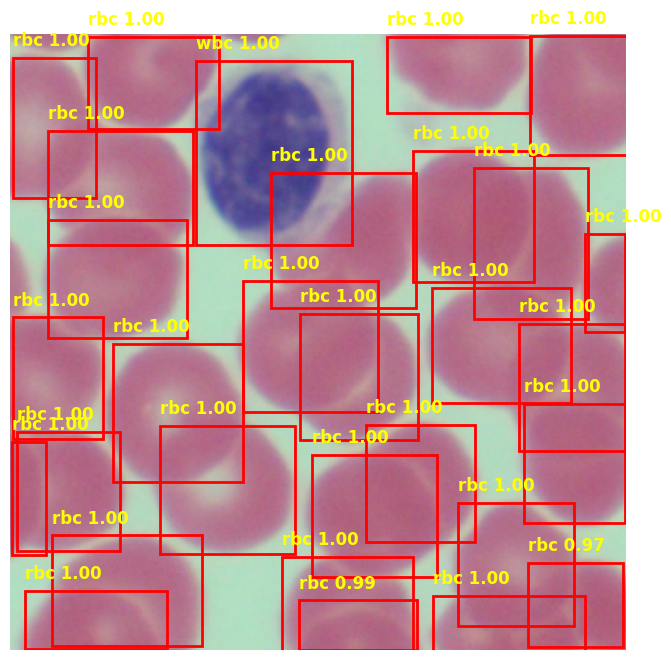

In [23]:
category_names = {cat["id"]: cat["name"] for cat in coco_gt.loadCats(coco_gt.getCatIds())}
image_path = "/kaggle/working/images/val/image-37.png"  

visualize_predictions(model_frcnn, image_path, coco_gt, category_names)


### show ssd sample


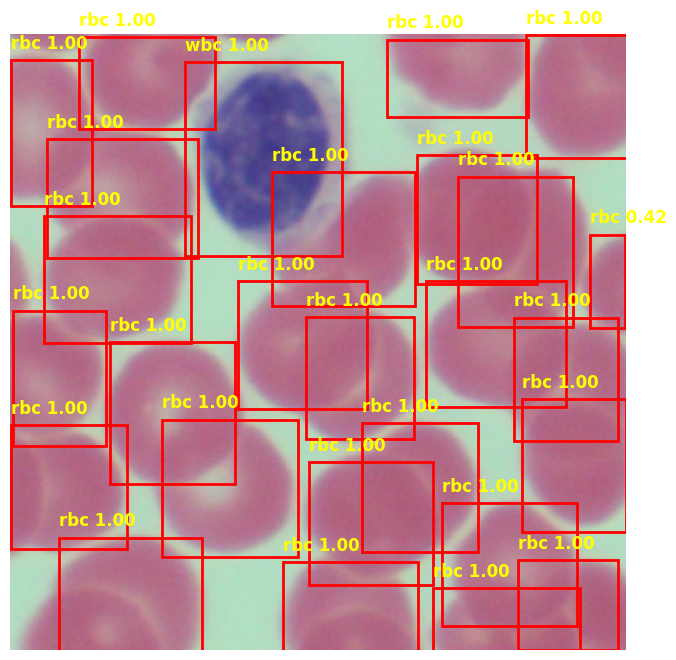

In [24]:

category_names = {cat["id"]: cat["name"] for cat in coco_gt.loadCats(coco_gt.getCatIds())}


image_path = "/kaggle/working/images/val/image-37.png"  

visualize_predictions(model_ssd, image_path, coco_gt, category_names)

# Different model performance compare

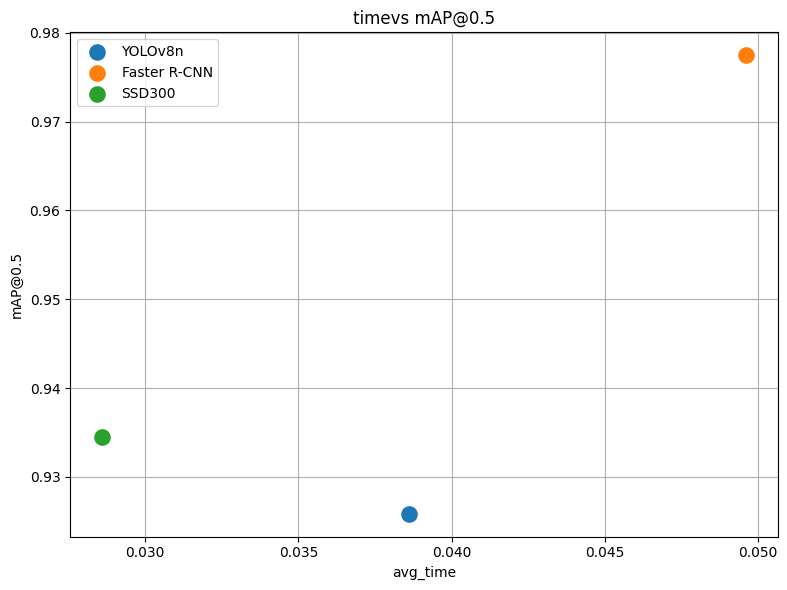

In [25]:

# time vs mAP@0.5


models = ["YOLOv8n",  "Faster R-CNN", "SSD300"]
map_50 = [yolo_performance["mAP@0.5"],  fasterrcnn_performance["mAP@0.5"], ssd_performance["mAP@0.5"]]
infer_time = [yolo_performance["avg_infer_time"], fasterrcnn_performance["avg_infer_time"], ssd_performance["avg_infer_time"]]

plt.figure(figsize=(8, 6))
for i in range(len(models)):
    plt.scatter(infer_time[i], map_50[i], label=models[i], s=120)

plt.title("timevs mAP@0.5")
plt.xlabel("avg_time")
plt.ylabel("mAP@0.5")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


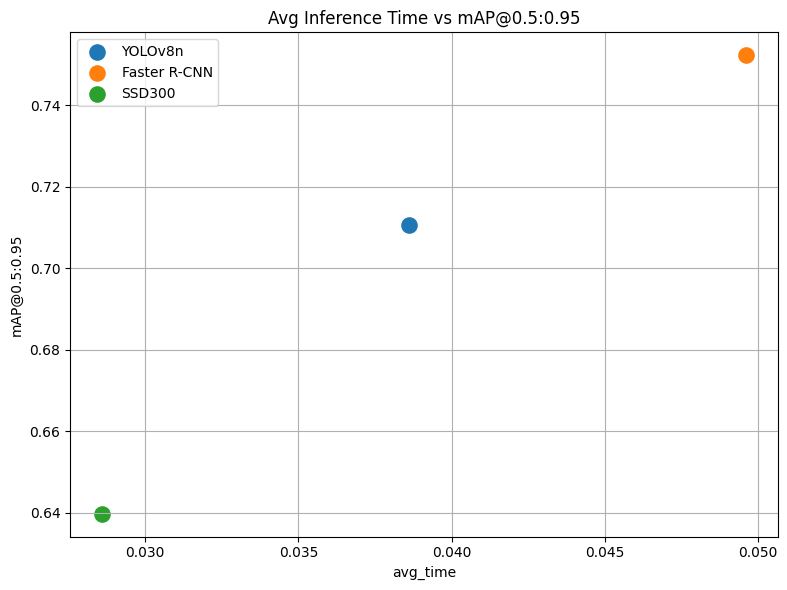

In [26]:
map_5095 = [yolo_performance["mAP@0.5:0.95"], fasterrcnn_performance["mAP@0.5:0.95"], ssd_performance["mAP@0.5:0.95"]]

plt.figure(figsize=(8, 6))
for i in range(len(models)):
    plt.scatter(infer_time[i], map_5095[i], label=models[i], s=120)

plt.title("Avg Inference Time vs mAP@0.5:0.95")
plt.xlabel("avg_time")
plt.ylabel("mAP@0.5:0.95")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


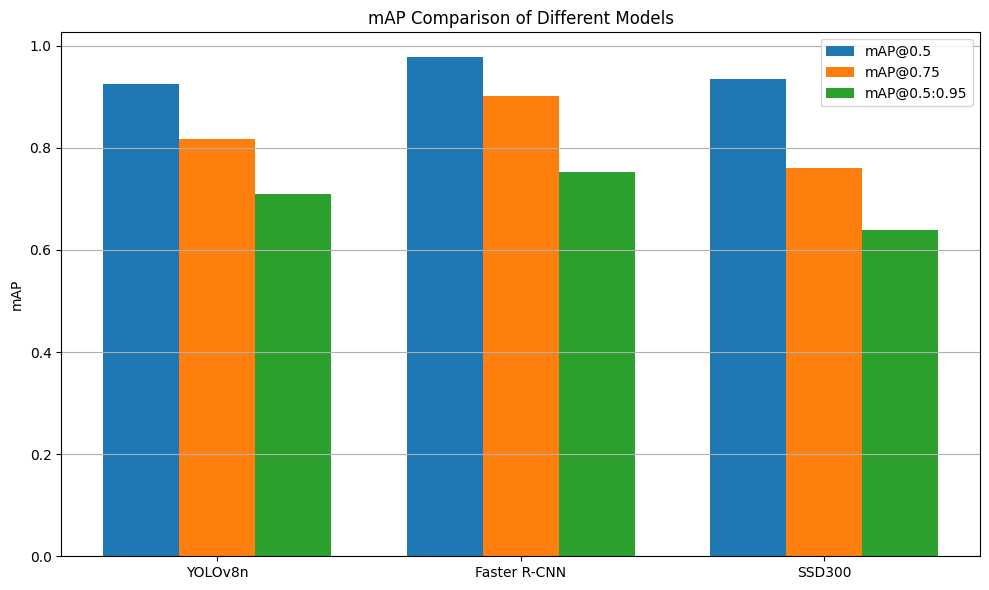

In [27]:
import numpy as np
map_75 = [yolo_performance["mAP@0.75"], fasterrcnn_performance["mAP@0.75"], ssd_performance["mAP@0.75"]]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, map_50, width, label='mAP@0.5')
plt.bar(x, map_75, width, label='mAP@0.75')
plt.bar(x + width, map_5095, width, label='mAP@0.5:0.95')

plt.xticks(x, models)
plt.ylabel("mAP")
plt.title("mAP Comparison of Different Models")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

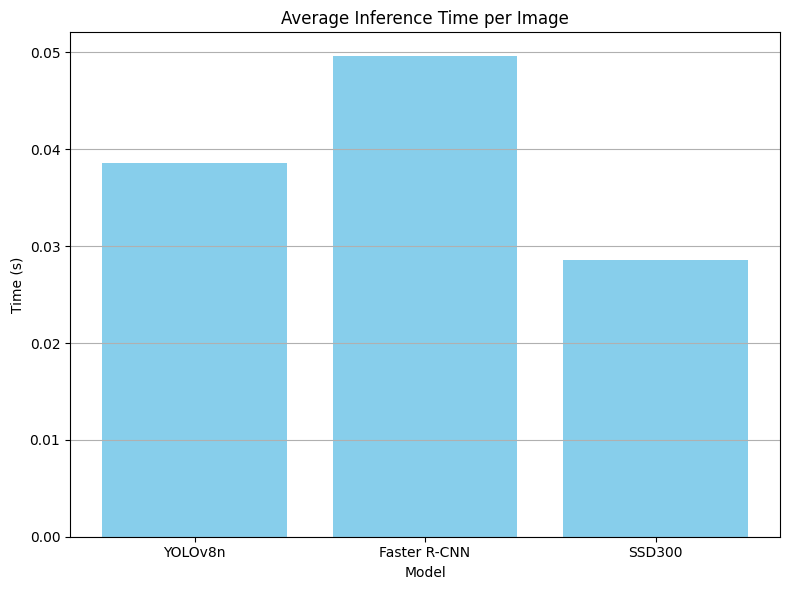

In [28]:
plt.figure(figsize=(8, 6))
plt.bar(models, infer_time, color='skyblue')
plt.title("Average Inference Time per Image")
plt.ylabel("Time (s)")
plt.xlabel("Model")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
